In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from image import *
from math import ceil

In [3]:
class Image:
    def __init__(self, img):
        self.img = img
        self.shape = img.shape
        self.keypoints, self.descriptors = get_sift_features(img)

    def show_features(self):
        img = cv2.drawKeypoints(image=self.img, keypoints=self.keypoints,
                                outImage=None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        show_image(img)
    
    def show(self, shape=(15, 15), img_type="bgr"):
        plt.rcParams["figure.figsize"] = shape
        if img_type == "bgr":
            plt.imshow(self.img[:, :, [2, 1, 0]])
        elif img_type.lower() == "gray":
            plt.imshow(self.img, cmap='gray')
        plt.show()
    

In [4]:
def read_images(directory):
    images = []
    for file in glob(directory):
        read_image = cv2.imread(file)
        present_flag = False
        for img in images:
            # Duplicate filter
            if (read_image == img).all():
                present_flag = True
                break
        if not present_flag:
            print('Appended file', file)
            images.append(read_image)
    return [Image(image) for image in images]

In [45]:
images = read_images(directory='../data/lake/*')

Appended file ../data/lake/MelakwaLake1.png
Appended file ../data/lake/MelakwaLake3.png
Appended file ../data/lake/MelakwaLake2.png


In [46]:
def ransac(matches, kp1, kp2, sample_points=4, iterations=5, inlier_tolerance=3, inlier_ratio=0.45, check = True, return_max_x = False):
    best_inlier_count = 0
    best_h = None
    best_inlier_indices = None
    
    # Get all the corresponing matching pairs for both the images
    pts1 = np.array([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.array([kp2[m.trainIdx].pt for m in matches])

    # Re-usable variables for all iterations
    homogeneous_pts1 = np.hstack((pts1, np.ones((pts1.shape[0], 1)))).T
    indices = np.arange(len(pts1))
    num_pts = pts1.shape[0]
    required_inliers = inlier_ratio * num_pts
    # For number of iterations
    for i in range(iterations):
        
        # Sample a small set of points from the point match pairs
        indices_to_sample = np.random.choice(indices, sample_points)
        pts1_sample = pts1[indices_to_sample]
        pts2_sample = pts2[indices_to_sample]
        
        # Get the homography matrix
        h = get_homography_matrix(pts1_sample, pts2_sample)
        
        # Find the new points using the homography matrix
        transformed_points = np.dot(h, homogeneous_pts1).T
        
        # Convert it to world coordinates
        last_col = np.copy(transformed_points[:, -1])
        last_col = last_col[:, np.newaxis]
        transformed_points /= last_col
        transformed_points = transformed_points[:, :-1]
        
        # Find the distance between the actual and the mapped points
        distance = np.linalg.norm(pts2 - transformed_points, axis = 1)
        inlier_indices = distance < inlier_tolerance
        inlier_count = inlier_indices.sum()
        if inlier_count > best_inlier_count:
            best_h = h
            best_inlier_indices = inlier_indices
            best_inlier_count = inlier_count
    
        if inlier_count > required_inliers:
            break

    if check:          
        transformed_points = np.dot(best_h, homogeneous_pts1).T
        # Convert it to world coordinates
        last_col = np.copy(transformed_points[:, -1])
        last_col = last_col[:, np.newaxis]
        transformed_points /= last_col
        transformed_points = transformed_points[:, :-1]
        distance = np.linalg.norm(pts2 - transformed_points, axis = 1)
        inlier_count = len(distance[distance < inlier_tolerance])
        print('%2.2f of the points are inliers'  %(inlier_count / num_pts * 100))
    if return_max_x:
        max_x_inlier_1 = ceil(pts1[best_inlier_indices].max(axis=0)[0])
        max_x_inlier_2 = ceil(pts2[best_inlier_indices].max(axis=0)[0])
        return best_h, max_x_inlier_1, max_x_inlier_2
    return best_h

In [47]:
'''
    Arranges 3 images in order for panorama
'''
def sort_images(images):
    if len(images) <=1:
        return
    
    num_images = len(images)
    matches_matrix = np.zeros((num_images, num_images))
    h_matrix = [[None for _ in range(num_images)] for _ in range(num_images)]
    max_x_matrix = [[None for _ in range(num_images)] for _ in range(num_images)]
    #Compute number of matches for all possible pairs
    for i in range(len(images)):
        for j in range(i+1, len(images)):
            matches = knn_matcher(images[i].descriptors, images[j].descriptors)
            matches_matrix[(i, j), (j, i)] = len(matches)
            h, img1_x, img2_x = ransac(matches, images[i].keypoints, images[j].keypoints,
                                sample_points=10, iterations=10000, check=False, return_max_x=True)
            max_x_matrix[i][j] = (img1_x, img2_x)
            max_x_matrix[j][i] = (img2_x, img1_x)
            h_matrix[i][j] = np.linalg.inv(h)
            h_matrix[j][i] = h
        #         inlier_list[i][j] = inlier_list[j][i] = inliers
    
    middle = np.argmax(matches_matrix.sum(axis=1))
    
    max_x_matrix[middle][middle] = (0,0)
#     if len(images=)
    left = np.array(max_x_matrix[middle]).argmax(axis=0)[0]
    right = 3 - middle - left
    images_ordered = [images[left], images[middle], images[right]]
    homographies = [h_matrix[middle][left], h_matrix[middle][right]]
    return images_ordered, homographies

In [48]:
images, homographies = sort_images(images)

In [49]:
homographies[0]

array([[ 6.20285507e-01, -6.39706884e-02,  1.63208657e+02],
       [-2.12597407e-01,  6.94509625e-01,  4.96294377e+01],
       [-5.63013602e-04, -2.96499509e-04,  1.00000000e+00]])

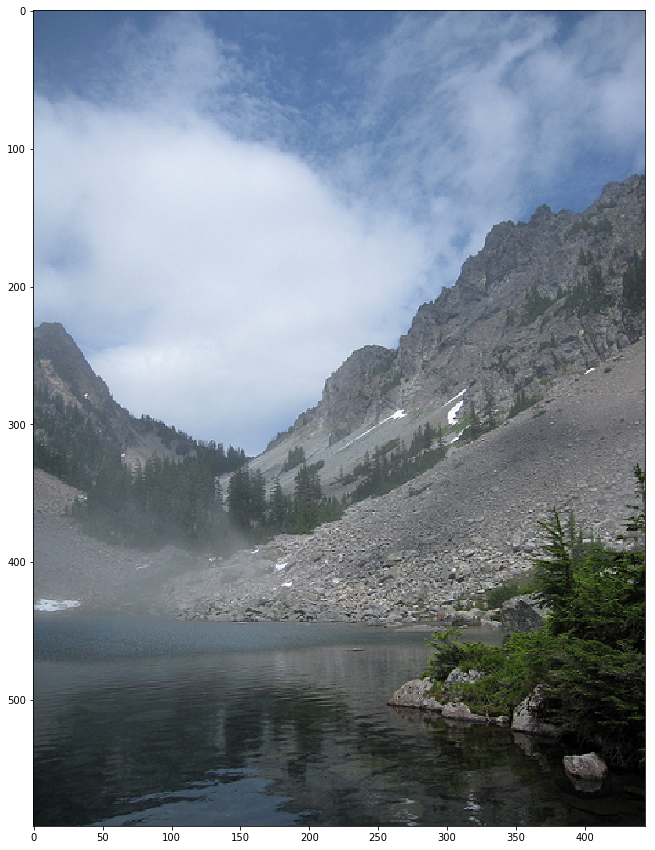

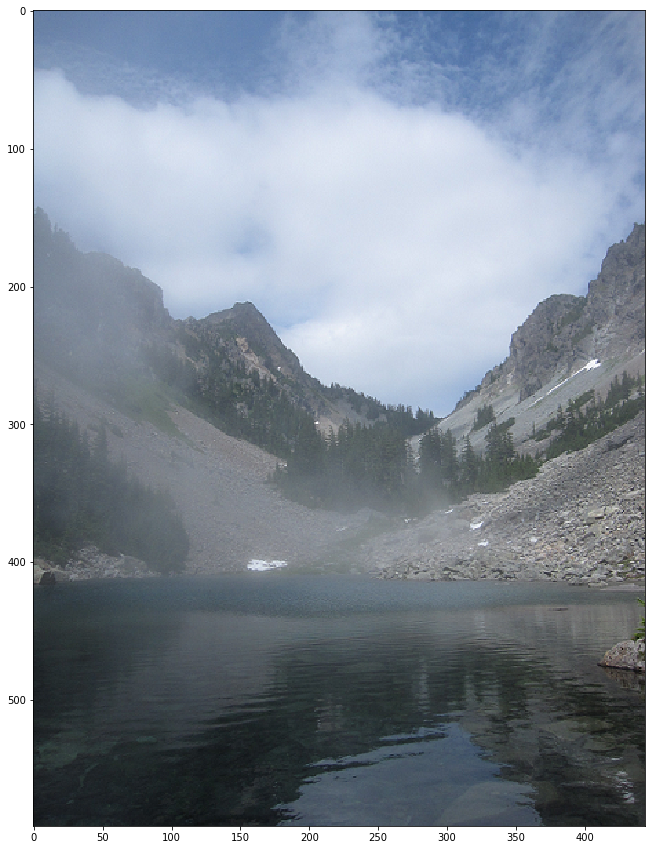

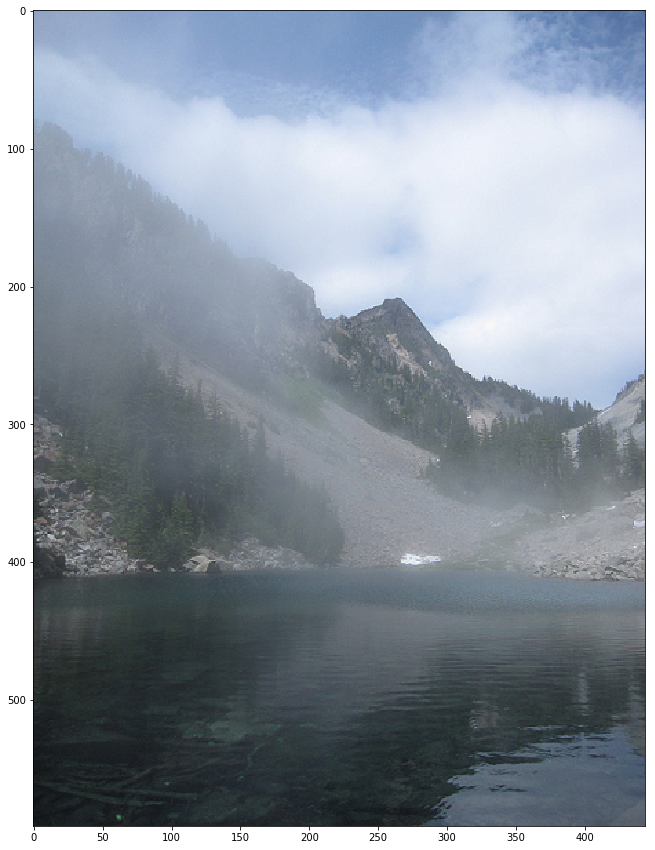

In [50]:
images[0].show()
images[1].show()
images[2].show()

[[ 6.20285507e-01 -6.39706884e-02  1.63208657e+02]
 [-2.12597407e-01  6.94509625e-01  4.96294377e+01]
 [-5.63013602e-04 -2.96499509e-04  1.00000000e+00]]


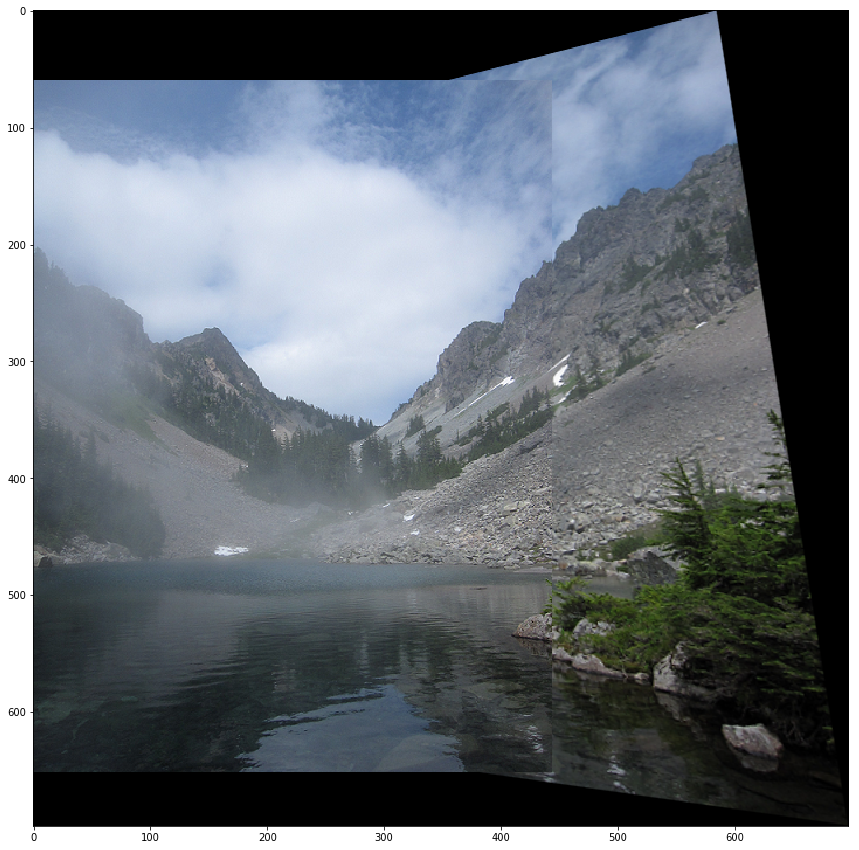

In [51]:
result = warpTwoImages(images[1].img, images[0].img, homographies[0])
show_image(result)


In [31]:
'''
    img2 ->right
    img1 ->left
'''
def stitch_two_images(img1, img2):
    matches = knn_matcher(img1.descriptors, img2.descriptors)

    h = ransac(matches, img1.keypoints, img2.keypoints, sample_points=10, iterations=10000, check=False)

    # # h_inv = np.linalg.inv(h)
    # # h_inv /= h_inv[-1,-1]
    result = warpTwoImages(img2.img, img1.img, h)
    show_image(result)
    return result

In [52]:
#https://stackoverflow.com/questions/13063201/how-to-show-the-whole-image-when-using-opencv-warpperspective
def warpTwoImages(img1, img2, h):
    '''warp img2 to img1 with homography h'''
    y1,x1 = img1.shape[:2]
    y2,x2 = img2.shape[:2]
    pts1 = np.array([[0,0],[0,y1],[x1,y1],[x1,0]], dtype = np.float32).reshape(-1,1,2)
    pts2 = np.array([[0,0],[0,y2],[x2,y2],[x2,0]], dtype=np.float32).reshape(-1,1,2)
    pts2_ = cv2.perspectiveTransform(pts2, h)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.array(pts.min(axis=0).flatten() - 0.5, dtype=np.int32)
    [xmax, ymax] = np.array(pts.max(axis=0).flatten() + 0.5, dtype=np.int32)
    warped_img = [-xmin,-ymin]
    h_dash = np.array([[1,0,warped_img[0]],[0,1,warped_img[1]],[0,0,1]]) # translate

    result = cv2.warpPerspective(img2, h_dash.dot(h), (xmax-xmin, ymax-ymin))
    result[warped_img[1]:y1+warped_img[1],warped_img[0]:x1+warped_img[0]] = img1
    return result


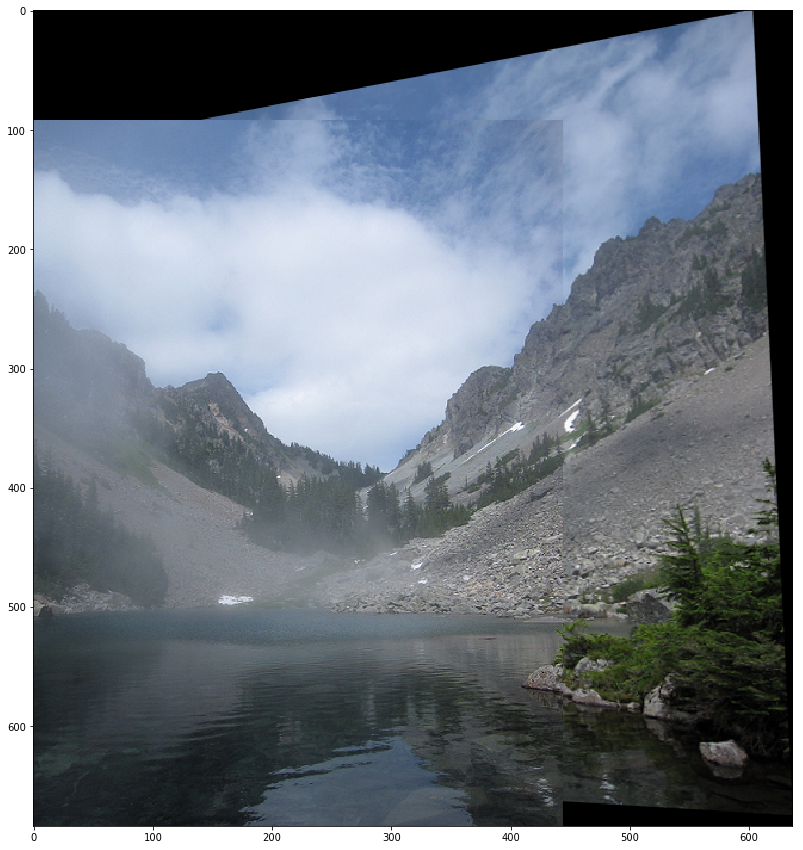

In [53]:
res2 = stitch_two_images(images[0],images[1])

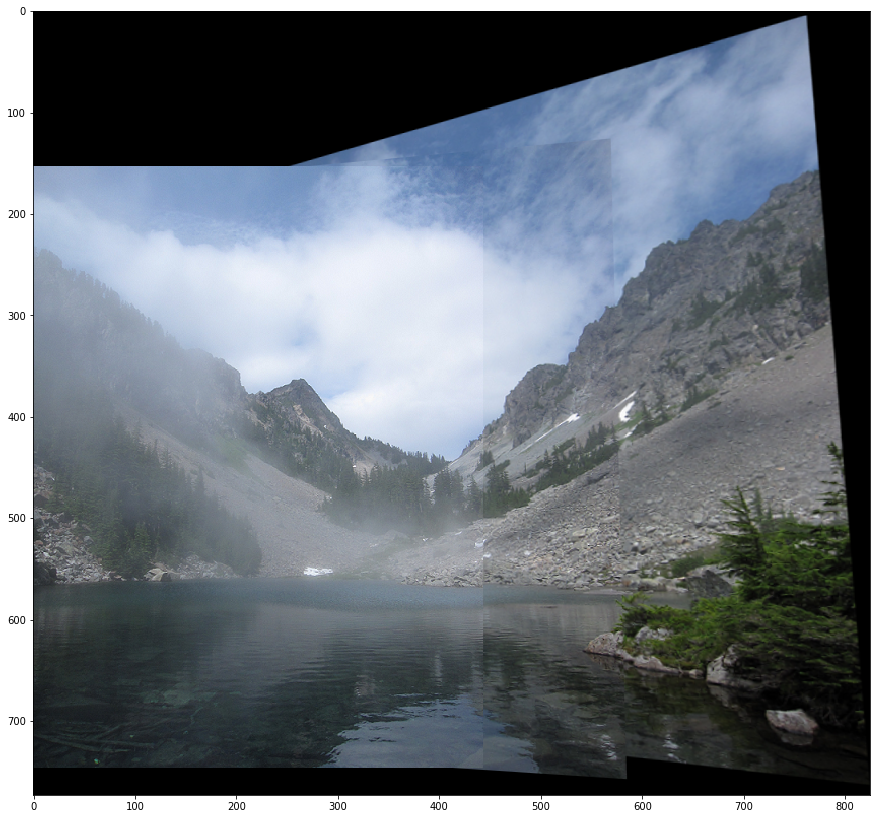

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [56]:
stitch_two_images(Image(res2), images[2])